In [1]:
from MahonyAHRS import MahonyAHRS
from quaternion_operations import quatern2euler, quaternConj, quatern2rotMat, quaternRotate
from scipy.signal import butter, filtfilt, welch
from scipy.integrate import trapz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
accel = pd.read_csv('my_data/VID_20240110_143256accel.csv').to_numpy()
gyro = pd.read_csv('my_data/VID_20240110_143256gyro.csv').to_numpy()
time = pd.read_csv('my_data/VID_20240110_143256_imu_timestamps.csv').to_numpy()
# data = pd.read_csv(
#     "F:\\NITS\\Projects\\Drone Project\\Experiment\\readings.csv")
# gyro = data.iloc[:, :3].to_numpy()
# gyro[:, 0] = gyro[:, 0] - 0.0016973518130000002
# gyro[:, 1] = gyro[:, 1] - 0.0094583359236
# gyro[:, 2] = gyro[:, 2] - 0.0013094289468000002
# accel = data.iloc[:, 3:6].to_numpy()
# accel[:, 0] = accel[:, 0] + 0.0001320315342
# accel[:, 1] = accel[:, 1] + 6.880012799999999e-06
# accel[:, 2] = accel[:, 2] - 0.0340683106088
# time = data.iloc[:, 6].to_numpy()
len(accel), len(gyro), len(time)

(3373, 3371, 3373)

In [8]:
accel = accel[:-2, :]
time = time[:-2, :]
len(accel), len(time)

(3371, 3371)

In [9]:
init_time = np.copy(time[0])
for t in range(len(time)):
    time[t] = time[t] - init_time

In [10]:
time = time * 1e-9
time[-1]

array([8.3753949])

In [13]:
sample_period = 0

for t in range(1, len(time)):
    sample_period += time[t] - time[t - 1]

sample_period /= len(time)

sample_period

array([0.00248454])

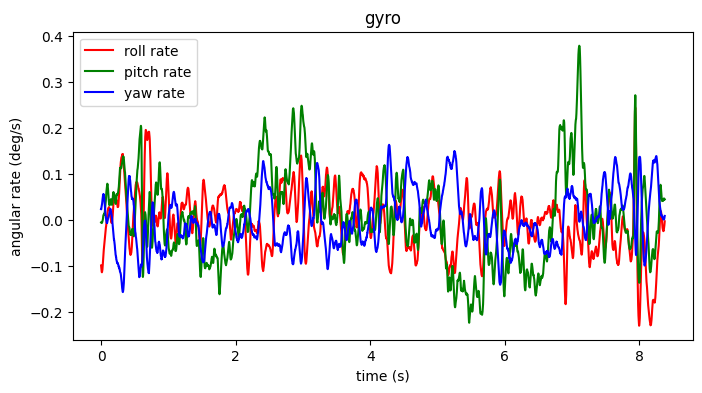

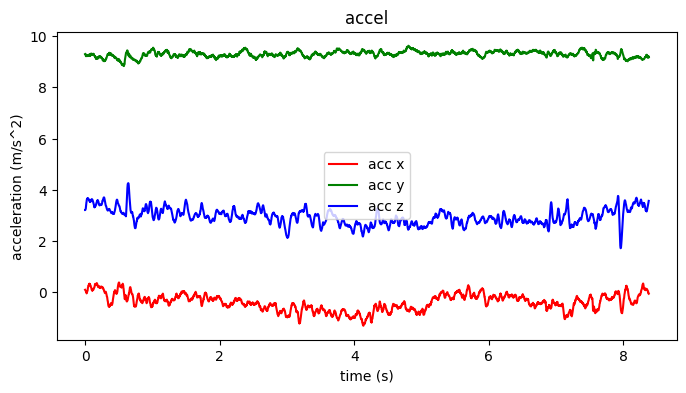

In [14]:
# Data plotting
# for gyro
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, gyro[:, 0], 'r', label="roll rate")
ax.plot(time, gyro[:, 1], 'g', label="pitch rate")
ax.plot(time, gyro[:, 2], 'b', label="yaw rate")
ax.set_title("gyro")
ax.set_xlabel('time (s)')
ax.set_ylabel("angular rate (deg/s)")
ax.legend()
# for acc
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, accel[:, 0], 'r', label="acc x")
ax.plot(time, accel[:, 1], 'g', label="acc y")
ax.plot(time, accel[:, 2], 'b', label="acc z")
ax.set_title("accel")
ax.set_xlabel('time (s)')
ax.set_ylabel("acceleration (m/s^2)")
ax.legend()

plt.show()  # to much vigorous or abrupt motion

In [15]:
accX, accY, accZ = accel[:, 0], accel[:, 1], accel[:, 2]
gyroX, gyroY, gyroZ = gyro[:, 0], gyro[:, 1], gyro[:, 2]

In [16]:
## compute accel magnitude
acc_mag = np.sqrt(accX*accX + accY*accY + accZ*accZ)
## HP filter to accel data
filtCutOff = 0.0001
[b, a] = butter(1, (2*filtCutOff)/(1/sample_period), 'high')
acc_magFilt = filtfilt(b, a, acc_mag)
## compute abs value
acc_magFilt = np.abs(acc_magFilt)
## LP filter accel data
filtCutOff = 5
[b, a] = butter(1, (2*filtCutOff)/(1/sample_period), 'high')
acc_magFilt = filtfilt(b, a, acc_mag)
## threshold detection
stationary = acc_magFilt < 0.055

In [17]:
AHRS = MahonyAHRS(SamplePeriod=sample_period, Kp=1, Ki=0)
R = np.zeros(shape=(3, 3, len(time)))
quaternion = np.zeros((len(time), 4))

In [18]:
# initial convergance
initPeriod = 2
indexSel = np.arange(0, np.argmax(time > time[0] + initPeriod) + 1)
for i in range(2000):
    AHRS.UpdateIMU(np.array([0, 0, 0]), np.array([np.mean(
        accel[indexSel, 0]), np.mean(accel[indexSel, 1]), np.mean(accel[indexSel, 2])]))

In [19]:
for t in range(len(time)):
    if (stationary[t]):
        AHRS.Kp = 0.5
    else:
        AHRS.Kp = 0
    AHRS.UpdateIMU(np.copy(gyro[t]), np.copy(accel[t]))
    quaternion[t] = AHRS.Quaternion
    R[:, :, t] = quatern2rotMat(AHRS.Quaternion).T

In [20]:
# compute translational accel
# rotate accel from sensor frame to earth frame
# translational_accel = quaternRotate(accel, quaternConj(quaternion))

translational_accel = np.zeros_like(accel)
for t in range(len(time)):
    translational_accel[t] = R[:, :, t] @ accel[t].T

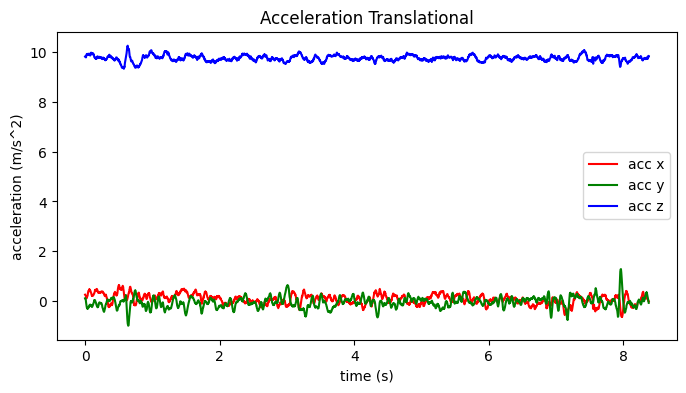

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, translational_accel[:, 0], 'r', label="acc x")
ax.plot(time, translational_accel[:, 1], 'g', label="acc y")
ax.plot(time, translational_accel[:, 2], 'b', label="acc z")
ax.set_title("Acceleration Translational")
ax.set_xlabel('time (s)')
ax.set_ylabel("acceleration (m/s^2)")
ax.legend()

In [22]:
# removing gravity component
# translational_accel[:, 2] = np.abs(translational_accel[:, 2]) - 1
# translational_accel = translational_accel * 9.81
translational_accel = translational_accel - np.array([0, 0, 9.8])

In [110]:
## finding when translational_accel magnitude is less than threshold --> will be considered to be as stationary
t_ax = translational_accel[:, 0]
t_ay = translational_accel[:, 1]
t_az = translational_accel[:, 2]
translational_accel_mag = np.sqrt(t_ax*t_ax + t_ay*t_ay + t_az*t_az)
t_stationary = translational_accel_mag < 0.05 ## translationaly stationary

In [111]:
_t = []
_acc = []
for t in range(len(time)):
    if (not t_stationary[t]):
        _acc.append(translational_accel[t])
        _t.append(t)
# print(_t), print(len(_t))
# print(_acc[:10])
_acc = np.array(_acc)
# np.min(_acc), np.max(_acc)
_acc[:20]

array([[ 0.24768972,  0.10383408,  0.03442708],
       [ 0.23487607,  0.10818328,  0.04028936],
       [ 0.22577443,  0.09865605,  0.04975583],
       [ 0.21739805,  0.08801531,  0.03429294],
       [ 0.20295461,  0.05193968,  0.01168091],
       [ 0.184132  , -0.02430486, -0.00286854],
       [ 0.16690698, -0.07146476,  0.01795995],
       [ 0.16444454, -0.12153049,  0.06879656],
       [ 0.17220986, -0.17600331,  0.08927839],
       [ 0.10192817, -0.20546315,  0.09075517],
       [ 0.12777081, -0.25681706,  0.13012165],
       [ 0.13853808, -0.27220777,  0.13267296],
       [ 0.15952742, -0.30643288,  0.10752539],
       [ 0.17890396, -0.2986728 ,  0.13958258],
       [ 0.19505074, -0.29038008,  0.12068264],
       [ 0.20458264, -0.31570585,  0.12540685],
       [ 0.26888233, -0.29778771,  0.13892936],
       [ 0.31726101, -0.3074971 ,  0.11571296],
       [ 0.32443846, -0.28618756,  0.13778252],
       [ 0.37539686, -0.27604977,  0.13137753]])

In [112]:
np.max(translational_accel_mag), np.min(translational_accel_mag)

(1.4150189723163287, 0.021024409434274704)

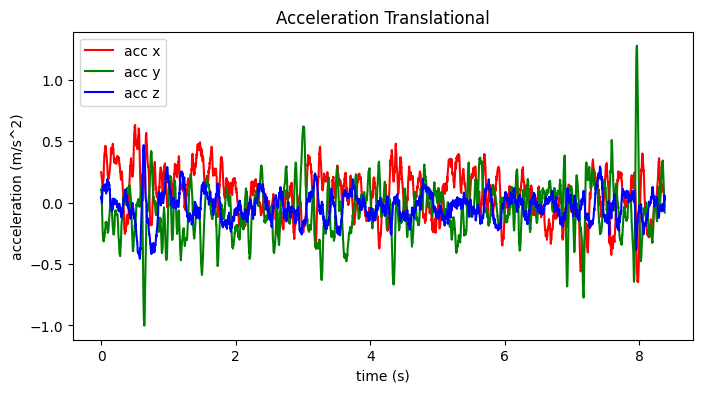

In [113]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, translational_accel[:, 0], 'r', label="acc x")
ax.plot(time, translational_accel[:, 1], 'g', label="acc y")
ax.plot(time, translational_accel[:, 2], 'b', label="acc z")
ax.set_title("Acceleration Translational")
ax.set_xlabel('time (s)')
ax.set_ylabel("acceleration (m/s^2)")
ax.legend()

In [114]:
len(time)

3371

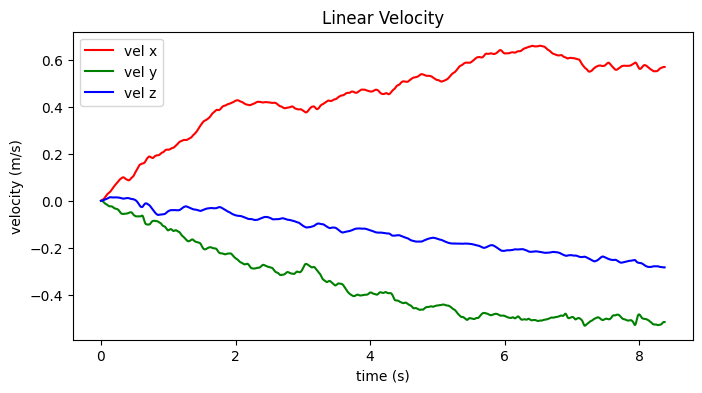

In [115]:
# calculate linear velocity (integrating acceleration)
vel = np.zeros_like(translational_accel)
for t in range(1, len(time)):
    if (t_stationary[t]):
        vel[t, :] = vel[t - 1, :]
    else:
        vel[t] = vel[t - 1] + translational_accel[t] * (time[t] - time[t - 1])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, vel[:, 0], 'r', label="vel x")
ax.plot(time, vel[:, 1], 'g', label="vel y")
ax.plot(time, vel[:, 2], 'b', label="vel z")
ax.set_title("Linear Velocity")
ax.set_xlabel('time (s)')
ax.set_ylabel("velocity (m/s)")
ax.legend()

In [116]:
# translational_accel[:20]
t_stationary[:20]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [117]:
vel[:20]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.81847207e-04,  2.67997237e-04,  9.98068914e-05],
       [ 1.14346314e-03,  5.13405042e-04,  2.23574959e-04],
       [ 1.68324294e-03,  7.31939138e-04,  3.08721236e-04],
       [ 2.18783803e-03,  8.61073955e-04,  3.37762844e-04],
       [ 2.64794339e-03,  8.00341448e-04,  3.30594981e-04],
       [ 3.06301719e-03,  6.22618802e-04,  3.75258819e-04],
       [ 3.47169313e-03,  3.20592435e-04,  5.46231349e-04],
       [ 3.89963187e-03, -1.16772965e-04,  7.68086725e-04],
       [ 4.15293440e-03, -6.27371087e-04,  9.93623116e-04],
       [ 4.46856102e-03, -1.26177498e-03,  1.31505690e-03],
       [ 4.81498518e-03, -1.94244956e-03,  1.64681491e-03],
       [ 5.21096046e-03, -2.70307020e-03,  1.91371197e-03],
       [ 5.65725214e-03, -3.44813579e-03,  2.26191299e-03],
       [ 6.14075212e-03, -4.16794213e-03,  2.56106620e-03],
       [ 6.64922017e-03, -4.95259492e-03,  2.87275138e-03],
       [ 7.31742153e-03, -5.69262924e-03

In [118]:
'''as we can see there is a drift in my calculated velocity and to remove drift from calculation we have to study power spectral density of noise to get the best filter'''
imu_data = pd.read_csv("F:\\NITS\\Projects\\Drone Project\\Experiment\\noise.csv")
gyro_noise = imu_data.iloc[:, :3]
accel_noise = imu_data.iloc[:, 3:]
# removing the mean
gyro_noise = gyro_noise - np.mean(gyro_noise, axis=0)
accel_noise = accel_noise - np.mean(accel_noise, axis=0)    
# Compute PSD for gyro and accel for each axis
sample_period_noise = 0.017
gyro_f_x, gyro_psd_x = welch(gyro_noise.iloc[:, 0], fs=1/sample_period_noise, window='hann', nperseg=len(time))
accel_f_x, accel_psd_x = welch(accel_noise.iloc[:, 0], fs=1/sample_period_noise, window='hann', nperseg=len(time))
gyro_f_y, gyro_psd_y = welch(gyro_noise.iloc[:, 1], fs=1/sample_period_noise, window='hann', nperseg=len(time))
accel_f_y, accel_psd_y = welch(accel_noise.iloc[:, 1], fs=1/sample_period_noise, window='hann', nperseg=len(time))
gyro_f_z, gyro_psd_z = welch(gyro_noise.iloc[:, 2], fs=1/sample_period_noise, window='hann', nperseg=len(time))
accel_f_z, accel_psd_z = welch(accel_noise.iloc[:, 2], fs=1/sample_period_noise, window='hann', nperseg=len(time))

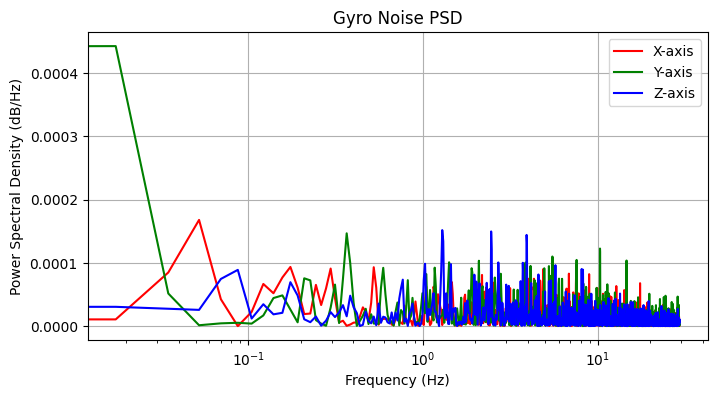

In [119]:
# plotting the gyro noise psd
plt.figure(figsize=(8, 4))
plt.semilogx(gyro_f_x, gyro_psd_x, label='X-axis', color='r')
plt.semilogx(gyro_f_y, gyro_psd_y, label='Y-axis', color='g')
plt.semilogx(gyro_f_z, gyro_psd_z, label='Z-axis', color='b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB/Hz)')
plt.title('Gyro Noise PSD')
plt.legend()
plt.grid(True)
plt.show()

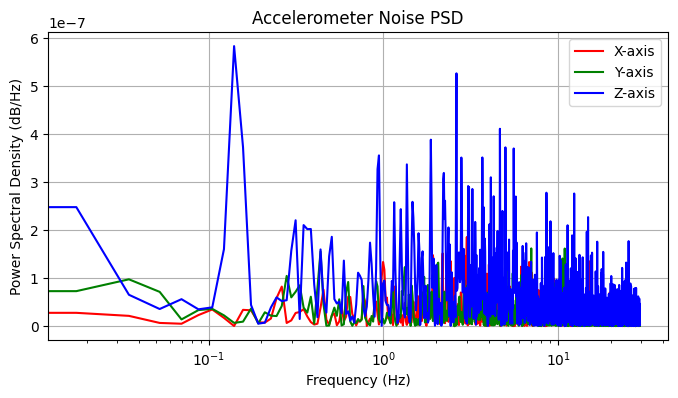

In [120]:
# plotting the accel noise psd
plt.figure(figsize=(8, 4))
plt.semilogx(accel_f_x, accel_psd_x, label='X-axis', color='r')
plt.semilogx(accel_f_y, accel_psd_y, label='Y-axis', color='g')
plt.semilogx(accel_f_z, accel_psd_z, label='Z-axis', color='b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB/Hz)')
plt.title('Accelerometer Noise PSD')
plt.legend()
plt.grid(True)
plt.show()

In [121]:
(1/sample_period)/2

array([201.24424218])

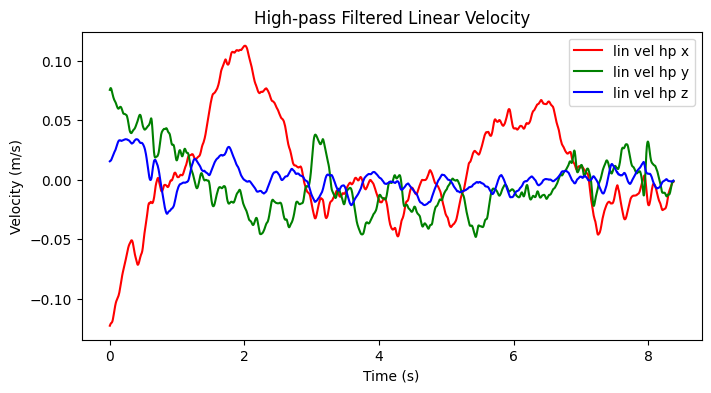

In [122]:
## considering cut-off freq of 10 Hz
order = 2
filtCutOff = 0.1
b, a = butter(order, (2 * filtCutOff) / (1/sample_period), 'high')
vel_hp = filtfilt(b, a, vel, axis=0)
# plotting liear velocity after high pass filtering
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, vel_hp[:, 0], 'r', label='lin vel hp x')
ax.plot(time, vel_hp[:, 1], 'g', label='lin vel hp y')
ax.plot(time, vel_hp[:, 2], 'b', label='lin vel hp z')
ax.set_title('High-pass Filtered Linear Velocity')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Velocity (m/s)')
ax.legend()

plt.show()

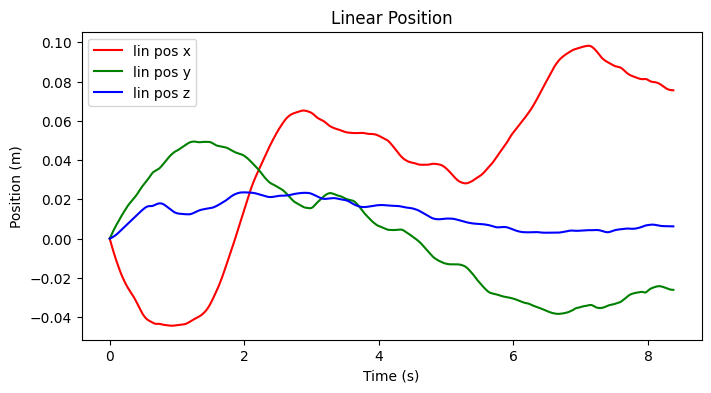

In [123]:
# calculate linear position (integrating velocity)
pos = np.zeros_like(vel_hp)
for t in range(1, len(time)):
    pos[t] = pos[t - 1] + vel_hp[t] * (time[t] - time[t - 1])
# plotting linear position
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, pos[:, 0], 'r', label='lin pos x')
ax.plot(time, pos[:, 1], 'g', label='lin pos y')
ax.plot(time, pos[:, 2], 'b', label='lin pos z')
ax.set_title('Linear Position')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Position (m)')
ax.legend()

plt.show()

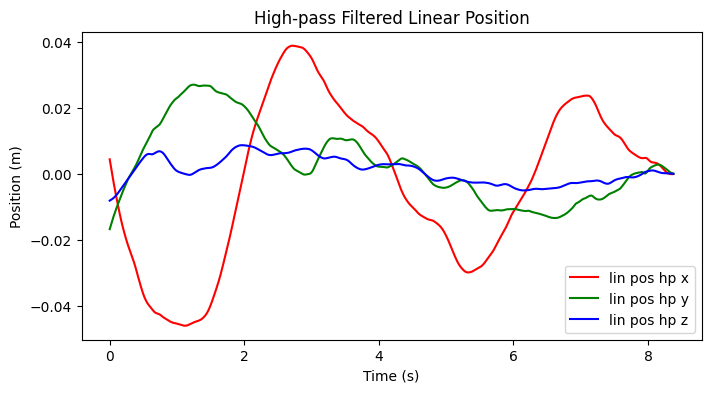

In [124]:
order = 2
filtCutOff = 0.1
b, a = butter(order, (2*filtCutOff)/(1/sample_period), 'high')
pos_hp = filtfilt(b, a, pos, axis=0)
# plotting linear position after high pass filtering
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, pos_hp[:, 0], 'r', label='lin pos hp x')
ax.plot(time, pos_hp[:, 1], 'g', label='lin pos hp y')
ax.plot(time, pos_hp[:, 2], 'b', label='lin pos hp z')
ax.set_title('High-pass Filtered Linear Position')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Position (m)')
ax.legend()

plt.show()

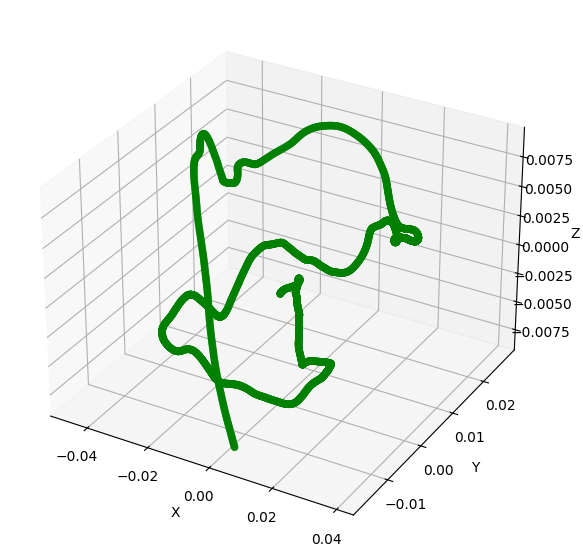

In [125]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(pos_hp[:, 0], pos_hp[:, 1], pos_hp[:, 2], color="green")
# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

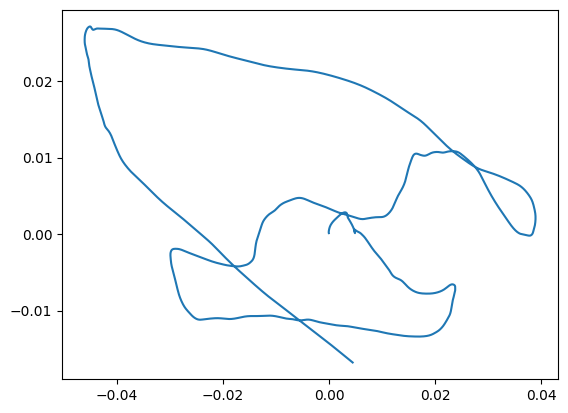

In [126]:
plt.plot(pos_hp[:, 0], pos_hp[:, 1])
plt.show()